# Projet 5 : Détection de piétons

Importations bibliothèques:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from skimage.feature import hog

# 1 Phase d'apprentissage 

1. Téléchargement image

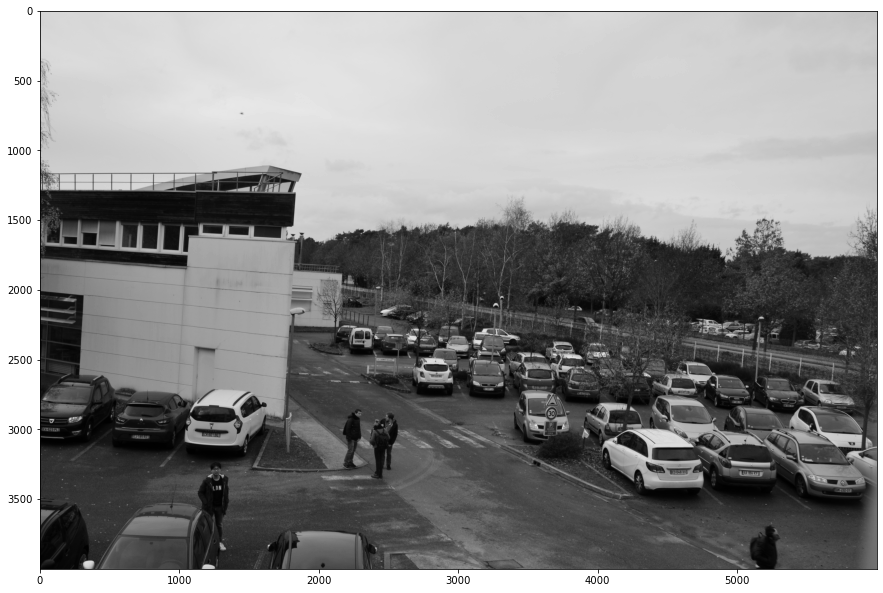

In [2]:
source = cv2.imread("DSC_0006.JPG",0)
plt.figure(figsize=(15,15))
plt.imshow(source,"gray")
plt.show()

2. Isole le piéton en une image 64*64

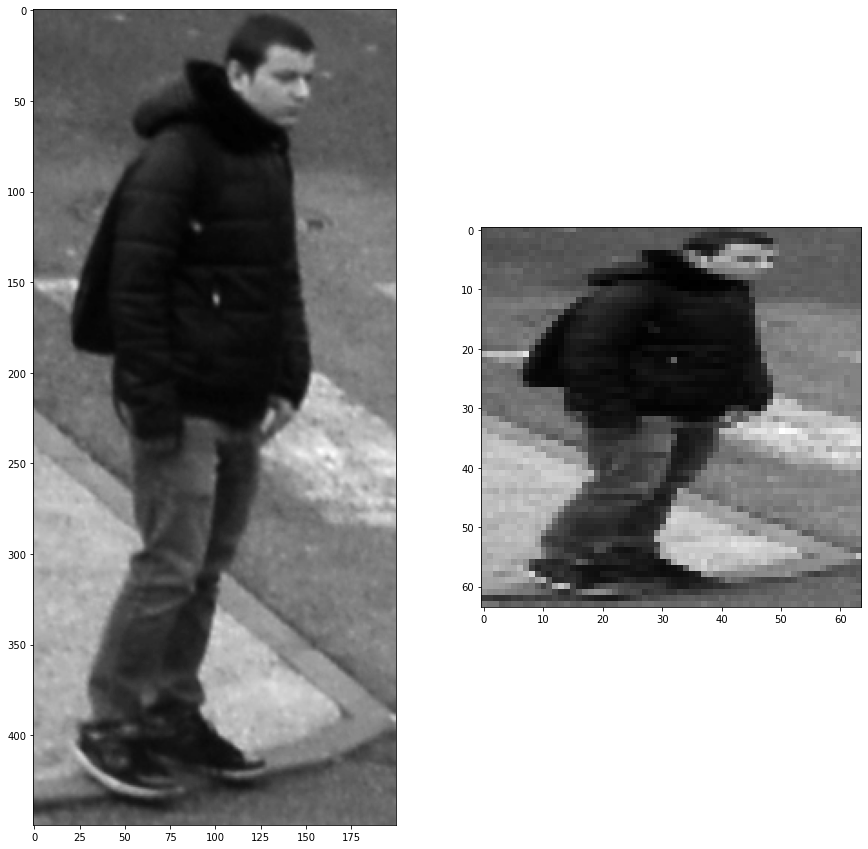

In [3]:
plt.figure(figsize=(15,15))
plt.subplot(121)
pieton = source[2850:3300,2150:2350]
plt.imshow(pieton,'gray')
plt.subplot(122)
pieton = cv2.resize(pieton,dsize=(64,64),interpolation=cv2.INTER_LINEAR)
plt.imshow(pieton,'gray')
plt.show()

3. Divise l'image en 8*8 carrés

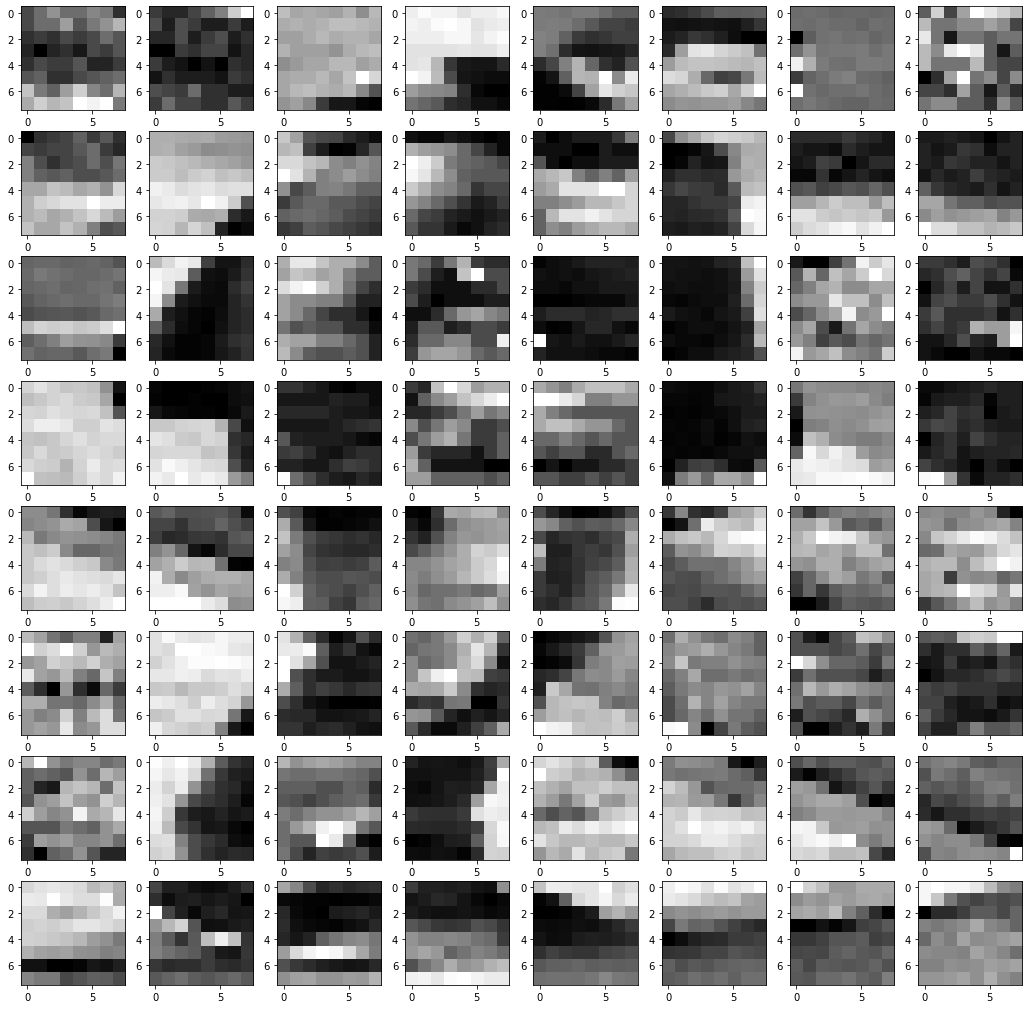

In [4]:
def get_blocks(source,dim_cell):
    blocks = []
    for i in range(0,dim_cell**2,dim_cell):
        for j in range(0,dim_cell**2,dim_cell):
            blocks.append(source[i:i+dim_cell,j:j+dim_cell])
    return blocks

pieton_blocks = get_blocks(pieton,8)
        
plt.figure(figsize=(18,18))
for i in range(len(pieton_blocks)):
    plt.subplot(8,8,i+1)
    plt.imshow(pieton_blocks[i],"gray")

4. HOG

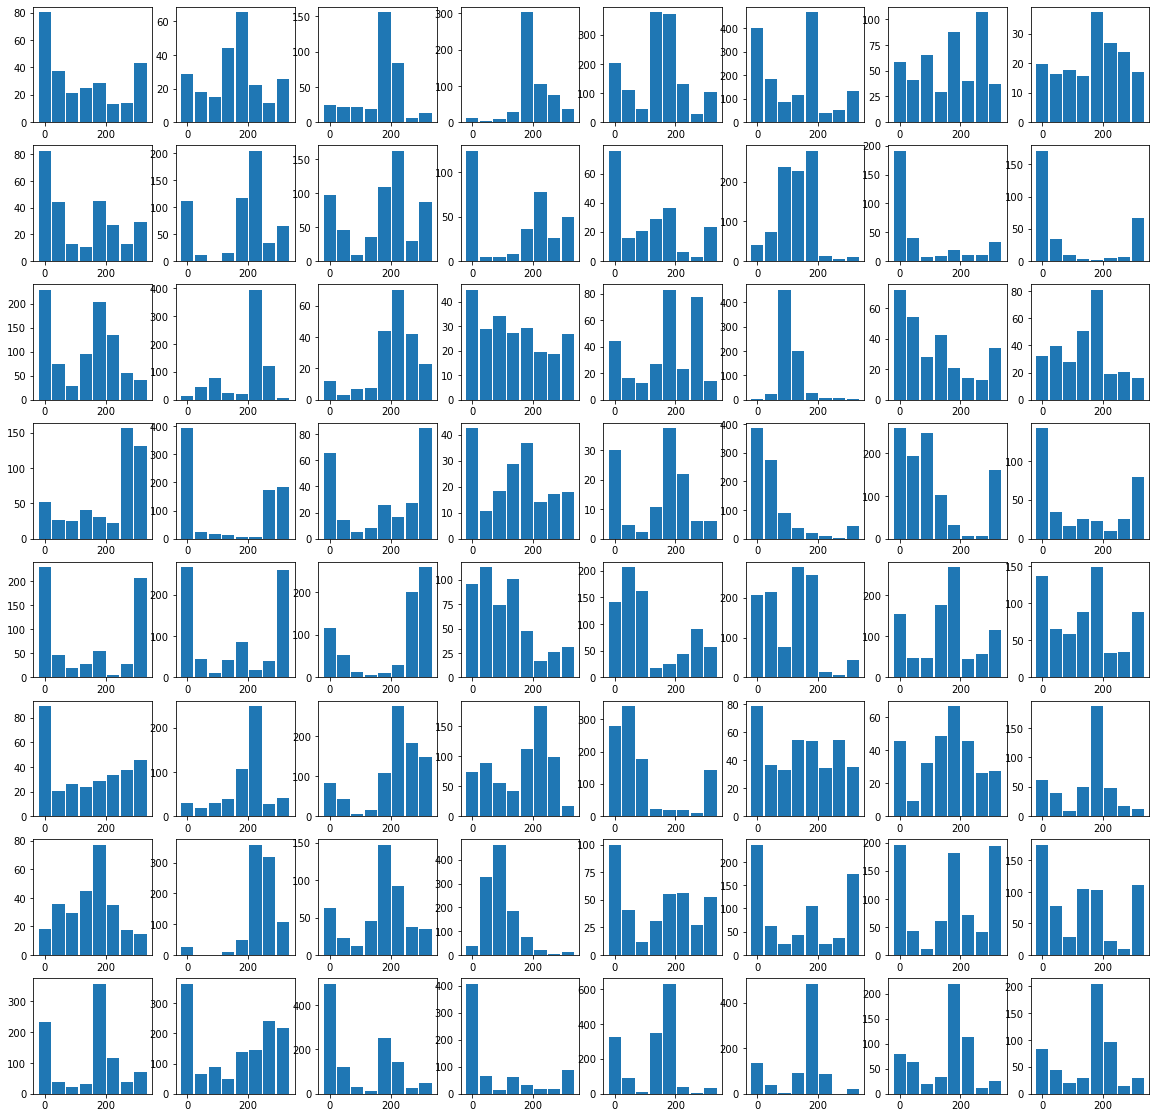

In [22]:
def get_magnitudes_orientations(block):
    dx, dy = np.gradient(block)
    magnitudes, orientations = cv2.cartToPolar(dx,dy, angleInDegrees=True)
    return magnitudes, orientations

def compute_hog_cell(n_orientations, block):
    magnitudes, orientations = get_magnitudes_orientations(block)
    bin_width = int(360 / n_orientations)
    hog = np.zeros(n_orientations)
    for i in range(orientations.shape[0]):
        for j in range(orientations.shape[1]):
            lower_bin_idx = int(orientations[i, j] / bin_width)
            pond_min = ((1+lower_bin_idx)*bin_width - orientations[i,j])/bin_width
            pond_max = (orientations[i,j] - lower_bin_idx*bin_width)/bin_width
            hog[lower_bin_idx] += magnitudes[i, j]*pond_min
            if lower_bin_idx < n_orientations-1:
                hog[lower_bin_idx+1] += magnitudes[i, j]*pond_max
            else:
                hog[0] += magnitudes[i, j]*pond_max
    return hog

n_orientations = 8 
hogs = []

for i in range(len(pieton_blocks)):
    hogs.append(compute_hog_cell(n_orientations,pieton_blocks[i]))

#affichage des HOGs
bin_width = int(360 / n_orientations)
angles = bin_width*np.arange(n_orientations)
plt.figure(figsize=(20,20))
for i in range(len(hogs)):
    plt.subplot(8,8,i+1)
    plt.bar(angles,hogs[i][:],width=0.9*int(360 / n_orientations))
plt.show()

Une étape de normalisation des hogs est indispensable pour que les résultats de détection soient convaincants malgré différnentes luminosités. Pour le moment, uniquement bloc par bloc mais une normalisation par bloc 16*16 serait préférable.

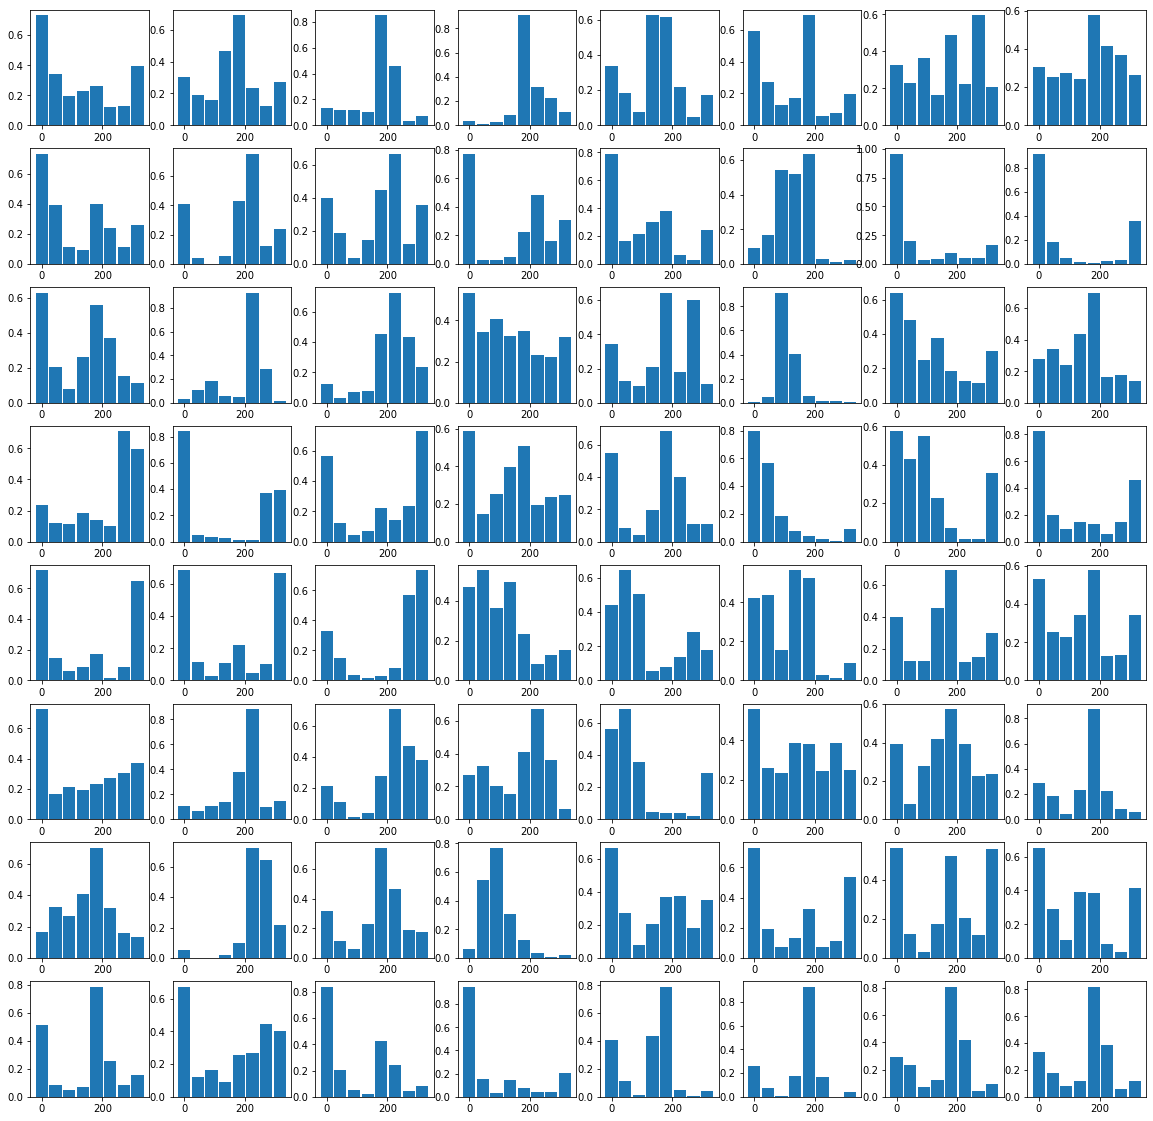

In [23]:
def normalize_hog(hogs):
    hogs = np.array(hogs)
    for i in range(len(hogs)):
        norm = np.linalg.norm(hogs[i,:],2)
        if norm > 0:
            hogs[i,:] = hogs[i,:]/norm
    return hogs

hogs = normalize_hog(hogs)

#affichage des HOGs
bin_width = int(360 / n_orientations)
angles = bin_width*np.arange(n_orientations)
plt.figure(figsize=(20,20))
for i in range(len(hogs)):
    plt.subplot(8,8,i+1)
    plt.bar(angles,hogs[i][:],width=0.9*int(360 / n_orientations))
plt.show()

On conserve maintenant l'orientation principale pour chaque cell, sous forme d'un vecteur de dimension 1*64

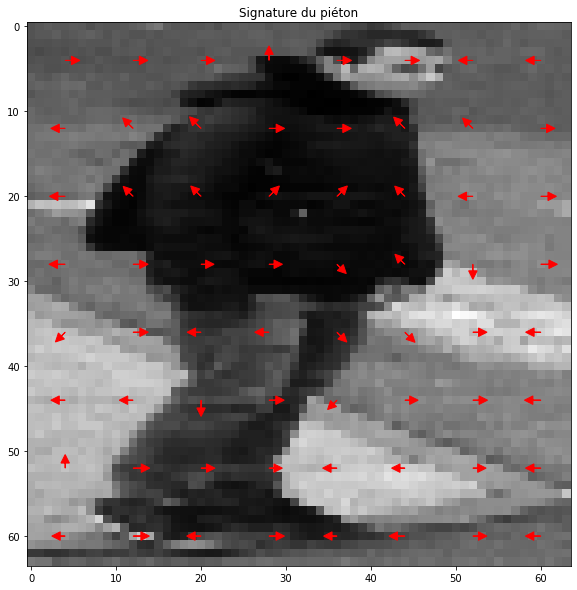

In [24]:
#retourne les coordonnées cartésiennes du vecteur principal du block
def vecteur_block(n_orientations,hogs): 
    x = np.zeros(len(hogs))
    y = np.zeros(len(hogs))
    bin_width = int(360 / n_orientations)
    for i in range(len(hogs)):
        angle = bin_width*np.argmax(hogs[i][:])
        magnitude = max(hogs[i][:])
        x[i] = magnitude*np.cos(angle*(np.pi/180)) 
        y[i] = magnitude*np.sin(angle*(np.pi/180))
    return x, y
    
composanteX_signature, composanteY_signature = vecteur_block(n_orientations,hogs)
signature = [composanteX_signature, composanteY_signature]

plt.figure(figsize=(10,10))
plt.title("Signature du piéton")
plt.imshow(pieton,"gray")

compteur = 0
for i in range(4,64,8):
    for j in range(4,64,8):
        plt.arrow(i, j, composanteX_signature[compteur], composanteY_signature[compteur],head_width = 1, head_length = 1, color = "r")
        compteur += 1
plt.show()

On obtient finallement la signature de notre piétion sous forme d'un vecteur. Celui-ci a été construit en conservant uniquement les vecteurs principaux des 64 premiers histogrammes.

A partir de cette signature nous allons pouvoir détécter les piétons sur le reste de l'image.

5. Fenêtre glissante pour detecter les piétons

In [25]:
def diffL1(signature,vecteur_block):
    return np.sum(np.abs(signature[0]-vecteur_block[0]) + np.abs(signature[1]-vecteur_block[1]))

def diffL2(signature,vecteur_block):
    return np.sum((np.abs(signature[0]-vecteur_block[0]))**2 + (np.abs(signature[1]-vecteur_block[1]))**2)

In [26]:
n_orientations = 8
dim_cell = 8
dim_block = dim_cell**2
rows, cols = source.shape
rows_pieton = 450
cols_pieton = 200 
step = 50
coords = []
diffs = []

for i in range(0,rows-rows_pieton,step):
    for j in range(0,cols-cols_pieton,step):
        image_analized = source[i:i+rows_pieton,j:j+cols_pieton]  #dimension du piéton initial
        image_analized = cv2.resize(image_analized,dsize=(64,64),interpolation=cv2.INTER_LINEAR)#reshape en 64*64
        blocks = get_blocks(image_analized,dim_cell)
        hog_cell = []
        for k in range(len(blocks)):
            hog_cell.append(compute_hog_cell(n_orientations,blocks[k]))
        hog_cell = normalize_hog(hog_cell) #normalisation
        vect_block = vecteur_block(n_orientations,hog_cell)
        coords.append((i,j))
        diffs.append(diffL1(signature,vect_block))

(2850, 2150) 0.0
coordonnées x:  2850
coordonnées y:  2150


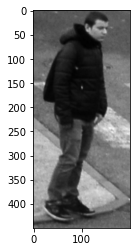

In [27]:
indice_min = diffs.index(min(diffs))
print(coords[indice_min],min(diffs))
print("coordonnées x: ",coords[indice_min][0])
print("coordonnées y: ",coords[indice_min][1])
plt.imshow(source[coords[indice_min][0]:coords[indice_min][0]+rows_pieton,coords[indice_min][1]:coords[indice_min][1]+cols_pieton],"gray")
plt.show()

Plutot cool, on retrouve pour le moment notre piéton, ce qui est une bonne chose. On utilise indirectement une heuristique qui est le fait de savoir à peu près la dimension de la feunêtre contenant un piéton.

## 2 Phase de test

5.

Testons maintenant notre algo de détéction de piéton sur une autre image mais en conservant la signature du piéton.

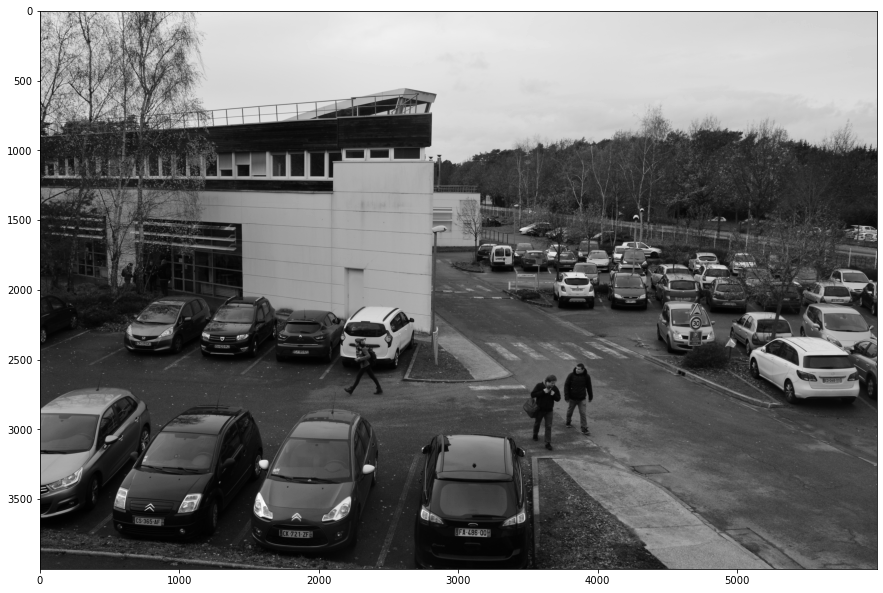

In [28]:
source9 = cv2.imread("DSC_0009.JPG",0)
plt.figure(figsize=(15,15))
plt.imshow(source9,"gray")
plt.show()

Recherchons une cible de notre hog detection

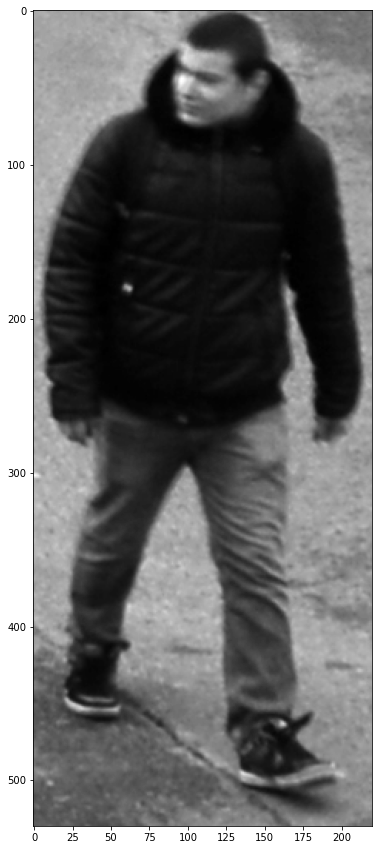

530 220


In [29]:
plt.figure(figsize=(15,15))
x = 2525
y = 3750
rows_pieton = 530
cols_pieton = 220
cible = source9[x:x+rows_pieton,y:y+cols_pieton]
plt.imshow(cible,"gray")
plt.show()
print(rows_pieton,cols_pieton)

(2950, 4875) 31.798173179375663
coordonnées x:  2950
coordonnées y:  4875


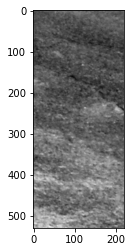

In [30]:
n_orientations = 8
dim_cell = 8
dim_block = dim_cell**2
rows, cols = source9.shape
rows_pieton = 530
cols_pieton = 220 
step = 25
coords = []
diffs = []

for i in range(0,rows-rows_pieton,step):
    for j in range(0,cols-cols_pieton,step):
        image_analized = source9[i:i+rows_pieton,j:j+cols_pieton]  #dimension du piéton initial
        image_analized = cv2.resize(image_analized,dsize=(64,64),interpolation=cv2.INTER_LINEAR)#reshape en 64*64
        blocks = get_blocks(image_analized,dim_cell)
        hog_cell = []
        for k in range(len(blocks)):
            hog_cell.append(compute_hog_cell(n_orientations,blocks[k]))
        hog_cell = normalize_hog(hog_cell) #normalisation
        vect_block = vecteur_block(n_orientations,hog_cell)
        coords.append((i,j))
        diffs.append(diffL2(signature,vect_block))
        
indice_min = diffs.index(min(diffs))
print(coords[indice_min],min(diffs))
print("coordonnées x: ",coords[indice_min][0])
print("coordonnées y: ",coords[indice_min][1])
plt.imshow(source9[coords[indice_min][0]:coords[indice_min][0]+rows_pieton,coords[indice_min][1]:coords[indice_min][1]+cols_pieton],"gray")
plt.show()

(2525, 3750) 63.55780488886177
coordonnées x:  2525
coordonnées y:  3750


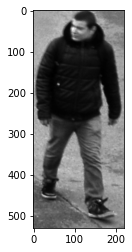

In [31]:
i = 2525
j = 3750
coords = []
diffs = []

image_analized = source9[i:i+rows_pieton,j:j+cols_pieton]  #dimension du piéton initial
image_analized = cv2.resize(image_analized,dsize=(64,64),interpolation=cv2.INTER_LINEAR)#reshape en 64*64
blocks = get_blocks(image_analized,dim_cell)
hog_cell = []
for k in range(len(blocks)):
    hog_cell.append(compute_hog_cell(n_orientations,blocks[k]))
hog_cell = normalize_hog(hog_cell) #normalisation
vect_block = vecteur_block(n_orientations,hog_cell)
coords.append((i,j))
diffs.append(diffL1(signature,vect_block))
        
indice_min = diffs.index(min(diffs))
print(coords[indice_min],min(diffs))
print("coordonnées x: ",coords[indice_min][0])
print("coordonnées y: ",coords[indice_min][1])
plt.imshow(source9[coords[indice_min][0]:coords[indice_min][0]+rows_pieton,coords[indice_min][1]:coords[indice_min][1]+cols_pieton],"gray")
plt.show()